# Transfer Learning

Implementação de um exemplo de `Transfer Learning` com a rede [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) para classificação de imagens de flores. Nesse exemplo utilizaremos a rede VGG16 pré treinada com a base [ImageNet](http://www.image-net.org/).

<img src='images/vgg16.png' width=60% />

A base [ImageNet](http://www.image-net.org/) possui mais de 14 milhões de imagens manualmente anotadas em cerca de 20 mil classes.


In [35]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [18]:
# define as transformacoes realizadas nas imagens de treinamento e teste
# imagens de tamanho 224 x 224 (tamanho padrao das imagens da VGG16/ImageNet)
dataset_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),    
}

# define os datasets de treinamento e teste
batch_size = 20
dataset_dir = 'datasets/flower_photos/'
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), dataset_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
n_classes = len(class_names)

print(f"Qtd de imagens de treinamento: {dataset_sizes['train']}")
print(f"Qtd de imagens de teste: {dataset_sizes['test']}")
print(f"Classes: {class_names}")

Qtd de imagens de treinamento: 3130
Qtd de imagens de teste: 540
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [19]:
# funcao auxiliar para exibir um conjunto de 'batch_size' imagens de exemplo
def dataset_show(images, labels, class_names, batch_size):
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(class_names[labels[idx]])

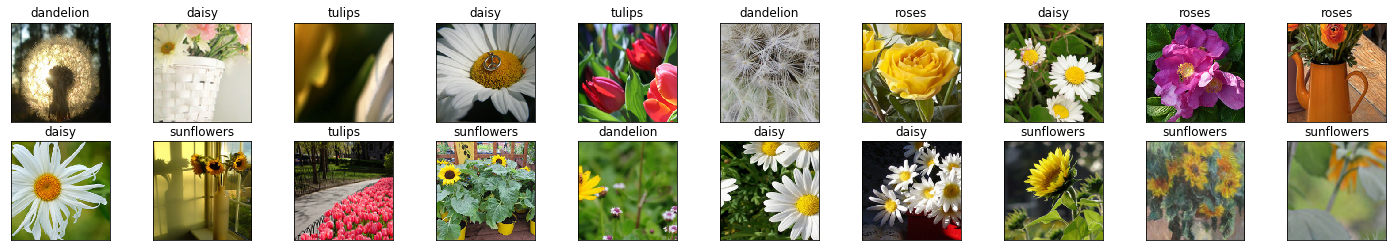

In [22]:
# pega um lote de tamanho 'batch_size' de imagens de treinamento e exibe
images, labels = next(iter(dataloaders['train'])) 
images = images.numpy() # convert images to numpy for display
dataset_show(images, labels, class_names, batch_size)
print(labels)

# Definindo o modelo

Para definir o modelo para treinamento é necessário realizar as seguintes etapas:

 1. Carregar o modelo VGG16 pré treinada
 2. "Congelar" todos os parâmetros da rede
 3. Remover a ultima camada da rede
 4. Alterar a ultima camada da rede por um novo classificador linear

*"Congelar" significa que os parâmetros do modelo pré treinado não sofrerão alterações durante o treinamento*

In [23]:
# Carrega o modelo VGG16 pre treinado do pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/dalifreire/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:35<00:00, 5797582.87it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [24]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [25]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Alterando a última camada da rede

Originalmente a rede `VGG16` classifica uma imagem entre 1000 classes. Vamos alterar a última camada da rede para realizar uma classificação entre 5 espécies de flores distintas.

In [31]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features
n_outputs = vgg16.classifier[6].out_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, n_classes)
vgg16.classifier[6] = last_layer

print("{} -> {}", n_inputs, n_outputs)
print("{} -> {}", n_inputs, n_classes)
print(vgg16)

5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv

# Função de perda e Otimizador

In [30]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

# Treinamento

In [33]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(dataloaders['train']):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.6354770481586456
Epoch 1, Batch 40 loss: 1.5698491454124450
Epoch 1, Batch 60 loss: 1.5881746411323547
Epoch 1, Batch 80 loss: 1.5601065993309020
Epoch 1, Batch 100 loss: 1.4843254327774047
Epoch 1, Batch 120 loss: 1.5001658678054810
Epoch 1, Batch 140 loss: 1.4624770283699036
Epoch 2, Batch 20 loss: 1.4132464706897736
Epoch 2, Batch 40 loss: 1.3852044820785523
Epoch 2, Batch 60 loss: 1.3801685214042663
Epoch 2, Batch 80 loss: 1.3118686079978943
Epoch 2, Batch 100 loss: 1.3383969783782959
Epoch 2, Batch 120 loss: 1.2981088846921920
Epoch 2, Batch 140 loss: 1.3306238591670989


# Teste

In [37]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in dataloaders['test']:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/dataset_sizes['test']
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.230632

Test Accuracy of tensor(0): 56% (52/92)
Test Accuracy of tensor(0): 93% (123/132)
Test Accuracy of tensor(0): 16% (15/91)
Test Accuracy of tensor(0): 56% (57/101)
Test Accuracy of tensor(0): 68% (85/124)

Test Accuracy (Overall): 61% (332/540)


# Visualizando alguns resultados de teste

tensor([[-0.3843, -0.3079, -0.2958,  0.5279,  0.6505],
        [-0.8035, -0.3902, -0.1773,  0.0176,  0.3447],
        [ 0.8236, -0.0886,  0.0353,  0.0136,  0.2703],
        [-0.2999, -0.6053,  0.4265,  0.0686,  0.7996],
        [ 0.2633,  0.4327, -0.4157,  0.4565, -0.2830],
        [-0.0892, -0.4831,  0.0565,  0.3472,  0.3906],
        [-0.0829,  0.4313,  0.0036,  0.0400,  0.2707],
        [ 0.0732,  0.2638, -0.3853,  0.6207,  0.1110],
        [-0.0186,  0.2063, -0.3181,  0.1787,  0.1507],
        [-0.4101,  0.0078,  0.2925,  0.3079,  0.2305],
        [-0.2249, -0.6206,  0.4008, -0.2065,  1.7106],
        [-0.1459,  0.9367, -0.4509, -0.2259, -0.1944],
        [-0.0930, -0.5339,  0.6523, -0.1794,  0.9051],
        [ 0.1392,  0.0655,  0.1208,  0.6725, -0.0189],
        [-0.3382, -0.2021,  0.4948,  0.5507,  0.4171],
        [ 0.2248, -0.4017,  0.3035, -0.2425,  0.7523],
        [ 0.4385,  0.4575, -0.0646,  0.0183,  0.0244],
        [ 0.3049,  0.8585, -0.5105, -0.0738, -0.1348],
        [-

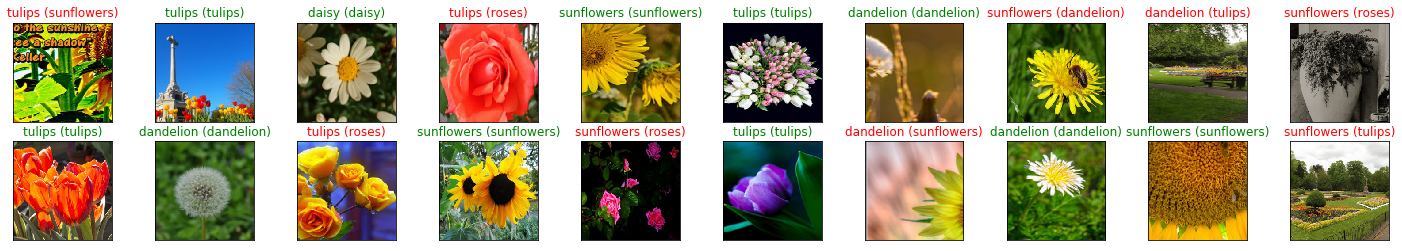

In [45]:
# pega um lote de tamanho 'batch_size' de imagens de treinamento
images, labels = next(iter(dataloaders['test'])) 
images.numpy()

# get sample outputs
output = vgg16(images)
print(output)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
print(preds)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))